In [101]:
%matplotlib inline
import numpy as np
import quaternion
import clifford as cf
import math

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import subprocess
import os

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from matplotlib.collections import PolyCollection

plt.style.use('default_colors.mplstyle')

In [102]:
# укажем директорию, в которую будем 
# сохранять сгенерированные картинки
FOLDER = 'spindogs'
try:
    os.mkdir(FOLDER)
except FileExistsError:
    pass

In [103]:
# Считываем таксу
# Вершины и грани (faces) в виде треугольников
Vd = []
Fd = []

with open(file='Dachshund.obj', mode='r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.startswith('#'):
            continue
        values = line.split()
        if not values:
            continue
        # вершины
        if values[0] == 'v':
            Vd.append(np.asarray(values[1:4], dtype=float))
        elif values[0] == 'f':
            Fd.append(np.asarray([v.split('/')[0] for v in values[1:4]], dtype=int))

Vd = np.array(Vd)
# Для использования F в качестве индексов для массива V надо из 
# всех элементов F вычесть 1
Fd = np.array(Fd)-1

Vd = (Vd - 0.5*(Vd.max(axis=0) + Vd.min(axis=0))) / max(Vd.max(axis=0) - Vd.min(axis=0))

In [104]:
# Считываем мопса
# Вершины и грани (faces) в виде треугольников
Vp = []
Fp = []

with open(file='pug.obj', mode='r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.startswith('#'):
            continue
        values = line.split()
        if not values:
            continue
        # вершины
        if values[0] == 'v':
            Vp.append(np.asarray(values[1:4], dtype=float))
        elif values[0] == 'f':
            Fp.append(np.asarray([v.split('/')[0] for v in values[1:4]], dtype=int))

Vp = np.array(Vp)
# Для использования F в качестве индексов для массива V надо из 
# всех элементов F вычесть 1
Fp = np.array(Fp)-1

Vp = (Vp - 0.5*(Vp.max(axis=0) + Vp.min(axis=0))) / max(Vp.max(axis=0) - Vp.min(axis=0))

In [105]:
def rotate_ga(X, α, U):
    U_norm = U/np.linalg.norm(U)
    u = (U_norm[0]*e1 + U_norm[1]*e2 + U_norm[2]*e3).right_complement()
    
    R = math.cos(α/2) - math.sin(α/2)*u
    
    s = X.shape[0]
    X_new = np.zeros([s, 3])
    
    for i in range(s):
        p = X[i][0]*e1 + X[i][1]*e2 + X[i][2]*e3
        p_new = R*p*R.conjugate()
        X_new[i] = p_new.value[1], p_new.value[2], p_new.value[3]
    return X_new

In [106]:
def rotate_quat(X, α, U):
    u = np.normalized(np.quaternion(*U))
    
    q = math.cos(α/2) + math.sin(α/2)*u
    
    s = X.shape[0]
    X_new = np.zeros([s, 3])
    
    for i in range(s):
        quat = np.quaternion(0, X[i][0], X[i][1], X[i][2])
        quat_new = q*quat*q.conjugate()
        X_new[i] = quat_new.x, quat_new.y, quat_new.z
    return X_new

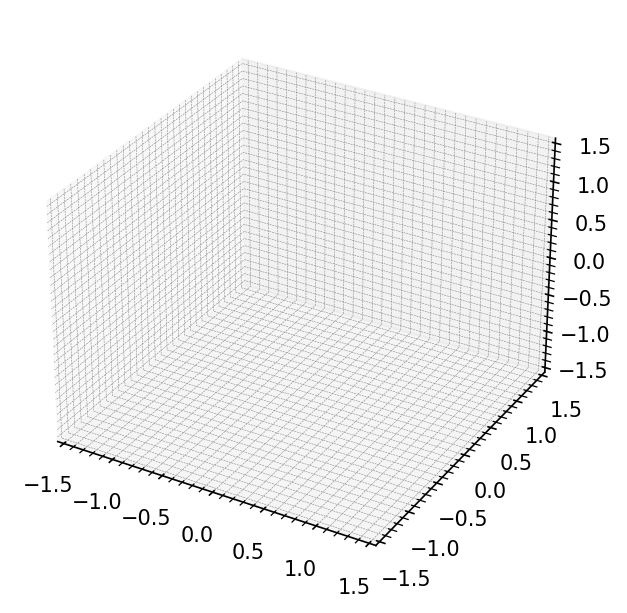

In [107]:
fig01 = plt.figure(num=1, figsize=(5, 5))
ax01 = fig01.add_subplot(1, 1, 1, projection='3d')

# Оформляем систему координат
ax01.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), zlim=(-1.5, 1.5), aspect='auto')

layout, blades = cf.Cl(3)
locals().update(blades)

Vd = rotate_ga(Vd, math.pi/2, [1, 0, 0]) # ставим собаку на ноги
Vd = rotate_ga(Vd, math.pi/2, [0, 0, 1]) # поворачиваем по курсу движения по окружности
Vd[:,:2] = Vd[:,:2] - 1 # сдвигаем относительно начала координат

Vp = rotate_quat(Vp, math.pi/2, [1, 0, 0])
Vp = rotate_quat(Vp, -math.pi/2, [0, 0, 1])
Vp[:,:2] = Vp[:,:2] + 1

# Вращение по кругу
α = np.linspace(0, 2*math.pi, 100)

U = np.array([0, 0, 10])

Vd_new = np.zeros([Vd.shape[0], 3])
Vp_new = np.zeros([Vp.shape[0], 3])

for i in range(100):
    Vd_new = rotate_ga(Vd, α[i], U)
    polygonsd = Vd_new[Fd]
    cold = Poly3DCollection(polygonsd, linewidth=0.1)
    ax01.add_collection3d(cold)
    
    Vp_new = rotate_quat(Vp, α[i], U)
    polygonsp = Vp_new[Fp]
    colp = Poly3DCollection(polygonsp, linewidth=0.1)
    ax01.add_collection3d(colp)
    
    fig01.savefig(f'{FOLDER}/{i:03d}.png', dpi=300, format='png')
    
    ax01.collections.remove(cold)
    ax01.collections.remove(colp)
    
    print('=', end='')

# Вращение вокруг себя на месте
Vd_new2 = np.zeros([Vd_new.shape[0], 3])
Vp_new2 = np.zeros([Vp_new.shape[0], 3])

for i in range(100):
    Vd_new2 = rotate_ga(Vd_new, α[i], [-1, -1, 0])
    polygonsd = Vd_new2[Fd]
    cold = Poly3DCollection(polygonsd, linewidth=0.1)
    ax01.add_collection3d(cold)
    
    Vp_new2 = rotate_quat(Vp_new, α[i], [1, 1, 0])
    polygonsp = Vp_new2[Fp]
    colp = Poly3DCollection(polygonsp, linewidth=0.1)
    ax01.add_collection3d(colp)
    
    fig01.savefig(f'{FOLDER}/{(100+i):03d}.png', dpi=300, format='png')
    
    ax01.collections.remove(cold)
    ax01.collections.remove(colp)
    
    print('=', end='')

# Догонялки. Такса настигает мопса
α = np.linspace(0, math.pi, 50)

Vd_new3 = np.zeros([Vd_new2.shape[0], 3])

ax01.add_collection3d(colp)

for i in range(50):
    Vd_new3 = rotate_ga(Vd_new2, α[i], U)
    polygonsd = Vd_new3[Fd]
    cold = Poly3DCollection(polygonsd, linewidth=0.1)
    ax01.add_collection3d(cold)
    
    fig01.savefig(f'{FOLDER}/{(200+i):03d}.png', dpi=300, format='png')
    
    ax01.collections.remove(cold)
    
    print('=', end='')

ax01.collections.remove(colp)    
    
# Мопс убегает от таксы
Vp_new3 = np.zeros([Vp_new2.shape[0], 3])

ax01.add_collection3d(cold)

for i in range(50):
    Vp_new3 = rotate_quat(Vp_new2, α[i], U)
    polygonsp = Vp_new3[Fp]
    colp = Poly3DCollection(polygonsp, linewidth=0.1)
    ax01.add_collection3d(colp)
    
    fig01.savefig(f'{FOLDER}/{(250+i):03d}.png', dpi=300, format='png')
    
    ax01.collections.remove(colp)
    
    print('=', end='')

ax01.collections.remove(cold)    

# Вращение вокруг себя на месте
α = np.linspace(0, 2*math.pi, 100)

Vd_new4 = np.zeros([Vd_new3.shape[0], 3])
Vp_new4 = np.zeros([Vp_new3.shape[0], 3])

for i in range(100):
    Vd_new4 = rotate_ga(Vd_new3, α[i], [1, 1, 0])
    polygonsd = Vd_new4[Fd]
    cold = Poly3DCollection(polygonsd, linewidth=0.1)
    ax01.add_collection3d(cold)
    
    Vp_new4 = rotate_quat(Vp_new3, α[i], [-1, -1, 0])
    polygonsp = Vp_new4[Fp]
    colp = Poly3DCollection(polygonsp, linewidth=0.1)
    ax01.add_collection3d(colp)
    
    fig01.savefig(f'{FOLDER}/{(300+i):03d}.png', dpi=300, format='png')
    
    ax01.collections.remove(cold)
    ax01.collections.remove(colp)
    
    print('=', end='')

In [108]:
FFMPEG = 'D:\\ffmpeg\\bin\\ffmpeg.exe'

CMD = [FFMPEG, '-y', '-r', '30', '-f', 'image2', '-i', f'{FOLDER}/%03d.png',
       '-vcodec', 'libx264', '-crf', '25', '-pix_fmt', 'yuv420p', 'spindogs.mp4']
print(' '.join(CMD))

out = subprocess.run(CMD, capture_output=True)
print(out.stderr.decode('utf-8'))

D:\ffmpeg\bin\ffmpeg.exe -y -r 30 -f image2 -i spindogs/%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p spindogs.mp4
ffmpeg version n4.4.1-2-gcc33e73618-20211107 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10-win32 (GCC) 20210610
  configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-libxml2 --enable-zlib --enable-libfreetype --enable-libfribidi --enable-gmp --enable-lzma --enable-fontconfig --enable-libvorbis --enable-opencl --enable-libvmaf --enable-vulkan --disable-libxcb --disable-xlib --enable-amf --enable-libaom --enable-avisynth --enable-libdav1d --enable-libdavs2 --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --disable-frei0r --enable-libglslang --enable-libgme --enable-libass --enable-libbluray --enable-libmp3lame --enable-libopus